issue: https://github.com/ioos/notebooks_demos/issues/351

GTS Statistics

The GTS monthly reports show the number of messages released to the GTS for each station. The reports contain the following fields:

Location ID - Identifier that station messages are released under to the GTS
Region - Designated IOOS Regional Association (only for IOOS regional report)
Sponsor - Organization that owns and maintains the station
Met - Total number of met messages released to the GTS
Wave - Total number of wave messages released to the GTS

# from ERDDAP

In [1]:
from datetime import date
from erddapy import ERDDAP


# currently the ERDDAP server has data from
# 2019-01-01T00:00:00Z to 2020-03-01T00:00:00Z
        
# date = date.today().strftime("%Y-%m")
date = "2020-03-01T00:00:00Z"

protocol = "tabledap"
server = "https://ferret.pmel.noaa.gov/generic/erddap"

e = ERDDAP(server=server, protocol=protocol)

e.dataset_id = "ioos_obs_counts"
e.variables = ["time", "locationID", "region", "sponsor", "met", "wave"]
e.constraints = {
    "time>=": date,
}

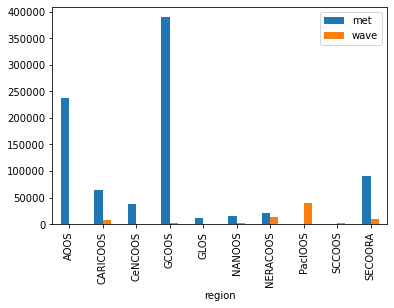

In [2]:
df = e.to_pandas()
df.head()
groups = df.groupby("region")
ax = groups.sum().plot(kind="bar")

## Everything for 2019 by month

In [3]:
import pandas as pd


e.constraints = {
    "time>=": "2019-01-01T00:00:00Z",
    "time<": "2020-01-01T00:00:00Z"
}

df = e.to_pandas()

In [4]:
df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
groups = df.groupby(pd.Grouper(key="time (UTC)", freq="M"))

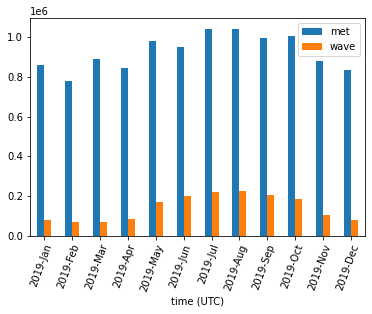

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots()

s = groups.sum()
s.plot(ax=ax, kind="bar")

ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"), rotation=70, rotation_mode="anchor", ha="right"
);

# From the site


https://www.ndbc.noaa.gov/ioosstats

In [ ]:
# Getting IOOS Regional, there is also NDBC, Non NDBC

dates = pd.date_range("2018-01", "2019-01", freq="M")
dates = dates.to_series().dt.strftime("%Y_%m")

dfs = {}
for date in dates:
    url = f"https://www.ndbc.noaa.gov/ioosstats/rpts/{date}_ioos_regional.csv"
    dfs.update({date: pd.read_csv(url)})